In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
np.random.seed(1)
IMG_SIZE = 196

### importowanie danych z pliku
* tytuly obrazkow z kotami zaczynaja sie od wielkiej litery
* konwertujemy zdjecia na czarnobiale by nie marnowac pamieci komputera (kolory maja znikomy wplyw na skutecznosc naszej seici neuronowej)
* DATA  - lista z obrazkami 
* LABELS - lista z zerami i jedynkami 0 - pies 1 - kot
* N - ilosc zdjec


In [9]:
DATADIR = os.path.curdir + '/images/images'

names = []
with os.scandir(DATADIR) as images: 
    for i, img in enumerate(images):
        if cv2.haveImageReader(os.path.join(DATADIR, img.name)) and '.jpg' in img.name:
            names.append(img.name)

### usuwanie nadmiarowych psow

* normalizacja
* normalizowanie rozmiarów zdjec


In [10]:
import os
import shutil
import random

def distribute_train_validation_split(validation_size=0.2):

    random.shuffle(names)

    all_dogs = list(filter(lambda image: image[0].isupper() == False, names))
    all_cats = list(filter(lambda image: image[0].isupper() == True, names))
    
    if len(all_cats)> len(all_dogs):
        all_cats = all_cats[:len(all_dogs)]
    elif len(all_cats)< len(all_dogs):
        all_dogs = all_dogs[:len(all_cats)]
        
    print(len(all_cats), len(all_dogs))
    index_to_split = int(len(all_dogs) - len(all_dogs) * validation_size)
    training_dogs = all_dogs[:index_to_split]
    validation_dogs = all_dogs[index_to_split:]
    training_cats = all_cats[:index_to_split]
    validation_cats = all_cats[index_to_split:]

    shutil.rmtree('./input_for_model')
    os.makedirs('./input_for_model/train/dogs/', exist_ok=True)
    os.makedirs('./input_for_model/train/cats/', exist_ok=True)
    os.makedirs('./input_for_model/test/dogs/', exist_ok=True)
    os.makedirs('./input_for_model/test/cats/', exist_ok=True)

    copy_images_to_dir(training_dogs, './input_for_model/train/dogs')
    copy_images_to_dir(validation_dogs, './input_for_model/test/dogs')
    copy_images_to_dir(training_cats, './input_for_model/train/cats')
    copy_images_to_dir(validation_cats, './input_for_model/test/cats')

def copy_images_to_dir(images_to_copy, destination):
    for image in images_to_copy:
        shutil.copyfile(f'./images/images/{image}', f'{destination}/{image}')

distribute_train_validation_split(0.2)

2394 2394


In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
# define cnn model
def define_model():
	# load model
	model = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                           kernel_regularizer=tf.keras.regularizers.l2(0.001))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [6]:
# define model
model = define_model()

In [16]:
# create data generator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0  )

In [17]:

train_it = datagen.flow_from_directory('input_for_model/train/',
	class_mode='binary', batch_size=64, target_size=(IMG_SIZE, IMG_SIZE))
test_it = datagen.flow_from_directory('input_for_model/test/',
	class_mode='binary', batch_size=64, target_size=(IMG_SIZE, IMG_SIZE))

Found 3830 images belonging to 2 classes.
Found 958 images belonging to 2 classes.


Epoch 1/20
60/60 [==============================] - 481s 8s/step - loss: 0.5572 - accuracy: 0.6914 - val_loss: 0.4203 - val_accuracy: 0.7912
Epoch 2/20
60/60 [==============================] - 465s 8s/step - loss: 0.3434 - accuracy: 0.8556 - val_loss: 0.3795 - val_accuracy: 0.8194
Epoch 3/20
60/60 [==============================] - 482s 8s/step - loss: 0.3080 - accuracy: 0.8655 - val_loss: 0.2645 - val_accuracy: 0.8935
Epoch 4/20
60/60 [==============================] - 466s 8s/step - loss: 0.2446 - accuracy: 0.9050 - val_loss: 0.2480 - val_accuracy: 0.8998
Epoch 5/20
60/60 [==============================] - 482s 8s/step - loss: 0.2191 - accuracy: 0.9185 - val_loss: 0.2335 - val_accuracy: 0.9071
Epoch 6/20
60/60 [==============================] - 467s 8s/step - loss: 0.2197 - accuracy: 0.9123 - val_loss: 0.2291 - val_accuracy: 0.9081
Epoch 7/20
60/60 [==============================] - 482s 8s/step - loss: 0.1882 - accuracy: 0.9269 - val_loss: 0.2573 - val_accuracy: 0.8935
Epoch 8/20
60

<AxesSubplot:>

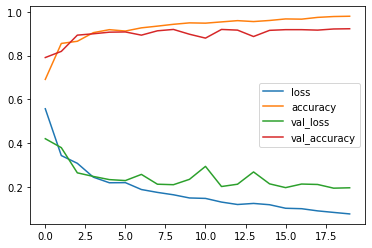

In [8]:

# fit model
history = model.fit(train_it, steps_per_epoch=len(train_it),
	validation_data=test_it, validation_steps=len(test_it), epochs=20)
pd.DataFrame(history.history).plot()

In [8]:
from tensorflow.keras.utils import plot_model

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 196, 196, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 196, 196, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 196, 196, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 98, 98, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 98, 98, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 98, 98, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 49, 49, 128)       0     

In [33]:

# evaluate model
_, acc = model.evaluate(test_it, steps=len(test_it), verbose=1)
print('> %.3f' % (acc * 100.0))

15/15 [==============================] - 111s 7s/step - loss: 0.1962 - accuracy: 0.9228
> 92.276


In [12]:
model.save('final_model_def.h5')

In [18]:
model = load_model('final_model_def.h5')
pred_t = np.array(model.predict(test_it), dtype=int)

In [4]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

# load and prepare the image


def load_image(filename):
    # load the image
    img = load_img(filename, target_size=(IMG_SIZE, IMG_SIZE))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 3 channels
    img = img.reshape(1, IMG_SIZE, IMG_SIZE, 3)
    # center pixel data
    img = img.astype('float32')
    img = img - [123.68, 116.779, 103.939]
    return img

# load an image and predict the class
def run_example():
    # load the image
    DIR = './input_for_model/test/'+np.random.choice(['cats', 'dogs'])+'/'
    path = DIR + np.random.choice(os.listdir(DIR))
    img = load_image(path)
    # load model
    model = load_model('final_model_def.h5')
    # predict the class
    class_names = ['kot', 'pies']
    plt.figure(figsize=(15, 10))
    plt.suptitle('predykcje modelu:', fontsize=16)
    for i in range(6):
        ax = plt.subplot(2, 3, i+1)

        #DIR = './input_for_model/test/'+np.random.choice(['cats', 'dogs'])+'/'
        DIR  = './martynix/'
        path = DIR + np.random.choice(os.listdir(DIR))
        img = load_image(path)
        plt.imshow(load_img(path))
        result = model.predict(img)
        pred_y = class_names[int(result[0][0])]
        color = "green"
        # if pred_y not in DIR:
        #     color = "red"
        plt.title((pred_y), color=color,fontsize=15)
        plt.axis(False)

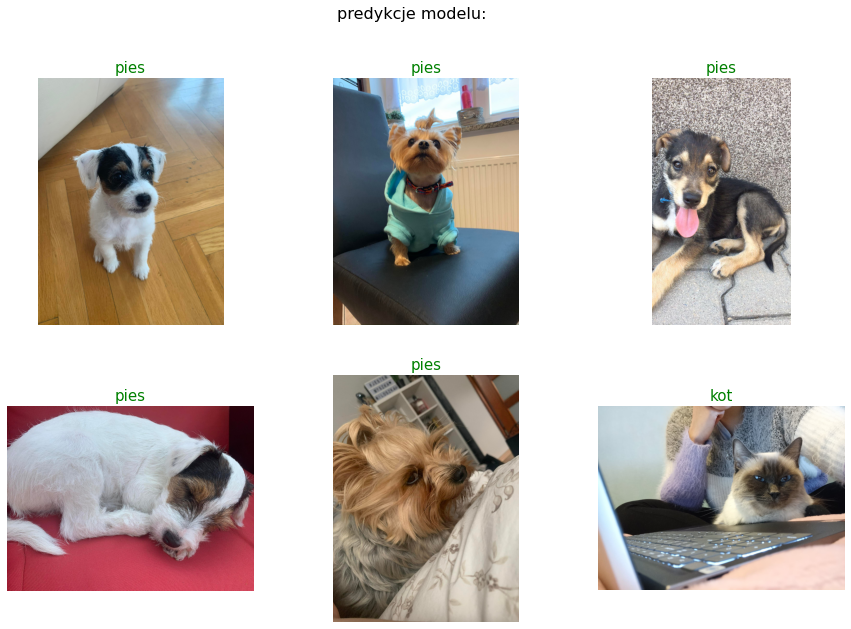

In [18]:
run_example()